In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Carregue seus dados aqui
df = pd.read_csv('../archive/male_players.csv', low_memory=False)
fifa_df = df[df['fifa_version'] <= 23]
# df.head()

In [3]:
fifa_df.isnull().sum()

fifa_df = fifa_df.dropna(subset=['overall', 'potential', 'value_eur'])

fifa_df['growth_potential'] = fifa_df['potential'] - fifa_df['overall']

fifa_df = fifa_df[['overall', 'potential', 'growth_potential', 'age', 'pace', 'shooting', 
         'passing', 'dribbling', 'defending', 'physic', 'international_reputation',
         'club_position', 'league_name', 'nationality_name', 'work_rate', 
         'release_clause_eur', 'value_eur']]

fifa_df.head()

,overall,potential,growth_potential,age,pace,shooting,passing,dribbling,defending,physic,international_reputation,club_position,league_name,nationality_name,work_rate,release_clause_eur,value_eur
18350,91,95,4,23,97.0,89.0,80.0,92.0,36.0,76.0,4,ST,Ligue 1,France,High/Low,366700000.0,190500000.0
18351,91,91,0,35,81.0,89.0,90.0,94.0,34.0,64.0,5,RW,Ligue 1,Argentina,Low/Low,99900000.0,54000000.0
18352,91,91,0,34,80.0,88.0,83.0,87.0,39.0,78.0,4,CF,La Liga,France,Medium/Medium,131200000.0,64000000.0
18353,91,91,0,33,75.0,91.0,79.0,86.0,44.0,83.0,5,ST,La Liga,Poland,High/Medium,172200000.0,84000000.0
18354,91,91,0,31,74.0,88.0,93.0,87.0,64.0,77.0,4,RCM,Premier League,Belgium,High/High,198900000.0,107500000.0


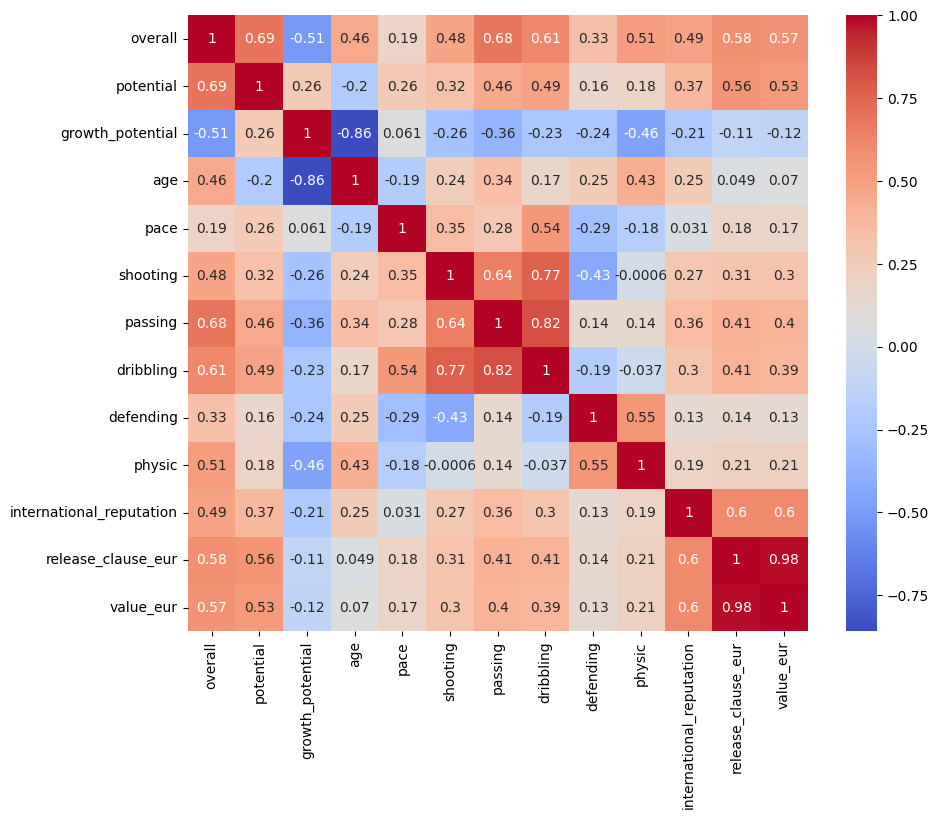

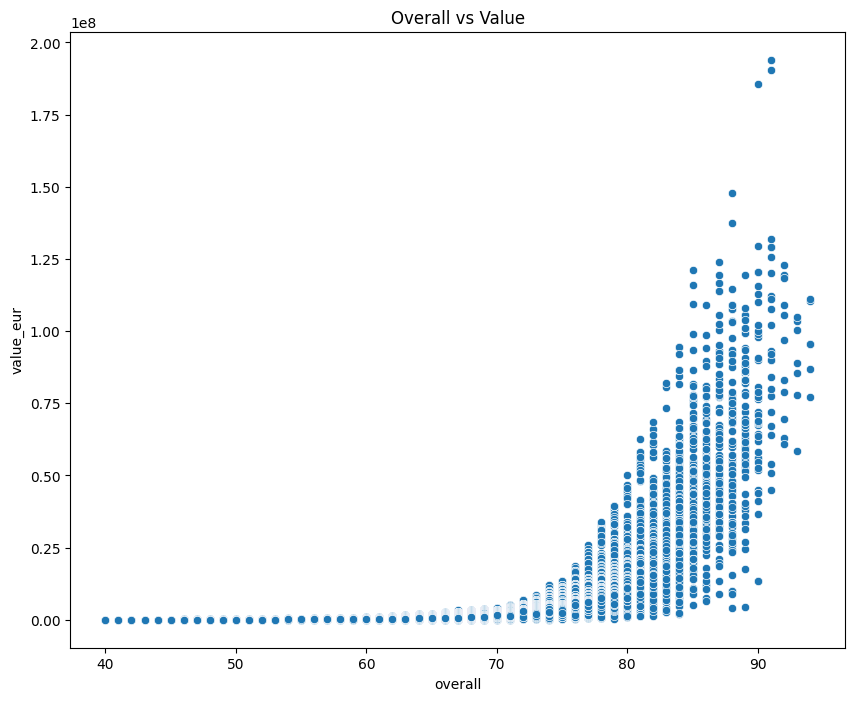

In [4]:
# Matriz de correlação
numeric_columns = fifa_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.show()

# Gráfico de dispersão entre 'overall' e 'value_eur'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='overall', y='value_eur', data=fifa_df)
plt.title('Overall vs Value')
plt.show()


In [5]:
# Definir X (features) e y (target)
X = fifa_df.drop(columns='value_eur')
y = fifa_df['value_eur']

# Dividir em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Definir o modelo base
rf = RandomForestRegressor(random_state=42)

# Definir os hiperparâmetros a serem ajustados
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],   
    'bootstrap': [True]          
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=10, 
                                   cv=5, random_state=42, n_jobs=-1, verbose=2)

# Ajustar o modelo
random_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_rf = random_search.best_estimator_

# Previsões nos dados de treino e teste
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Avaliação
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Resultados
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}
Train R2: 0.9915154341037998
Test R2: 0.9627060271536014


In [43]:
data = pd.read_csv('../archive/male_players.csv')

data.isnull().sum()

male_players = data[data['fifa_version'] >= 24]
male_players['growth_potential'] = male_players['potential'] - male_players['overall']

selected_columns =['short_name', 'overall', 'potential', 'growth_potential', 'age', 'pace', 
                    'shooting', 'passing', 'dribbling', 'defending', 'physic', 
                    'international_reputation', 'club_position', 'league_name', 
                    'nationality_name', 'work_rate', 'release_clause_eur', 'value_eur']

male_players = male_players[selected_columns]
male_players = male_players.dropna()

# Fazer previsões
male_players_predictions = best_rf.predict(
    male_players.drop(columns=['club_position', 'league_name', 'nationality_name', 'work_rate', 'short_name', 'value_eur'])
)

male_players['predicted_value_eur'] = male_players_predictions

male_players['predicted_value_eur'] = male_players['predicted_value_eur'].apply(lambda x: f"{x:,.0f} €")
male_players['value_eur'] = male_players['value_eur'].apply(lambda x: f"{x:,.0f} €")

male_players[['short_name','overall', 'potential', 'growth_potential', 'age', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'predicted_value_eur', 'value_eur']].nlargest(10, 'potential')


C:\Users\flavi\AppData\Local\Temp\ipykernel_11436\2922207172.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../archive/male_players.csv')
C:\Users\flavi\AppData\Local\Temp\ipykernel_11436\2922207172.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_players['growth_potential'] = male_players['potential'] - male_players['overall']


,short_name,overall,potential,growth_potential,age,pace,shooting,passing,dribbling,defending,physic,predicted_value_eur,value_eur
0,K. Mbappé,91,94,3,24,97.0,90.0,80.0,92.0,36.0,78.0,"158,218,092 €","181,500,000 €"
1,E. Haaland,91,94,3,22,89.0,93.0,66.0,80.0,45.0,88.0,"132,429,609 €","185,000,000 €"
8,Vini Jr.,89,94,5,22,95.0,82.0,78.0,90.0,29.0,68.0,"135,475,586 €","158,500,000 €"
35,J. Musiala,86,93,7,20,85.0,75.0,76.0,91.0,63.0,61.0,"117,435,462 €","134,500,000 €"
17,F. Valverde,88,92,4,24,88.0,82.0,84.0,84.0,80.0,82.0,"120,205,241 €","130,500,000 €"
36,K. Kvaratskhelia,86,92,6,22,84.0,80.0,81.0,87.0,41.0,71.0,"106,329,047 €","109,000,000 €"
37,Pedri,86,92,6,20,78.0,69.0,82.0,88.0,70.0,74.0,"118,198,504 €","105,000,000 €"
2,K. De Bruyne,91,91,0,32,72.0,88.0,94.0,87.0,65.0,78.0,"98,846,424 €","103,000,000 €"
18,V. Osimhen,88,91,3,24,90.0,86.0,66.0,83.0,42.0,82.0,"115,912,965 €","126,500,000 €"
38,Rafael Leão,86,91,5,24,93.0,80.0,75.0,87.0,27.0,76.0,"89,565,451 €","102,500,000 €"


In [45]:
data = pd.read_csv('../archive/female_players.csv')

data.isnull().sum()

female_players = data[data['fifa_version'] >= 24]
female_players['growth_potential'] = female_players['potential'] - female_players['overall']

selected_columns =['short_name', 'overall', 'potential', 'growth_potential', 'age', 'pace', 
                    'shooting', 'passing', 'dribbling', 'defending', 'physic', 
                    'international_reputation', 'club_position', 'league_name', 
                    'nationality_name', 'work_rate', 'release_clause_eur', 'value_eur']

female_players = female_players[selected_columns]
female_players = female_players.dropna()

# Fazer previsões
female_players_predictions = best_rf.predict(
    female_players.drop(columns=['club_position', 'league_name', 'nationality_name', 'work_rate', 'short_name', 'value_eur'])
)

female_players['predicted_value_eur'] = female_players_predictions

female_players['predicted_value_eur'] = female_players['predicted_value_eur'].apply(lambda x: f"{x:,.0f} €")
female_players['value_eur'] = female_players['value_eur'].apply(lambda x: f"{x:,.0f} €")

female_players[['short_name','overall', 'potential', 'growth_potential', 'age', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'predicted_value_eur', 'value_eur']].nlargest(10, 'potential')


C:\Users\flavi\AppData\Local\Temp\ipykernel_11436\2617296988.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_players['growth_potential'] = female_players['potential'] - female_players['overall']


,short_name,overall,potential,growth_potential,age,pace,shooting,passing,dribbling,defending,physic,predicted_value_eur,value_eur
1,Aitana Bonmatí,90,92,2,25,81.0,84.0,83.0,91.0,75.0,73.0,"123,979,431 €","149,000,000 €"
8,M. Katoto,88,92,4,24,83.0,88.0,77.0,84.0,39.0,71.0,"119,637,399 €","132,500,000 €"
0,Alexia Putellas,91,91,0,29,82.0,90.0,91.0,92.0,72.0,78.0,"123,174,637 €","127,500,000 €"
25,S. Bacha,86,91,5,22,87.0,72.0,84.0,82.0,79.0,78.0,"108,262,026 €","97,500,000 €"
2,C. Hansen,90,90,0,28,89.0,86.0,88.0,90.0,47.0,75.0,"121,462,124 €","120,500,000 €"
3,S. Kerr,90,90,0,29,85.0,88.0,74.0,90.0,42.0,85.0,"122,791,381 €","119,500,000 €"
4,Mapi León,89,90,1,28,75.0,74.0,81.0,76.0,90.0,81.0,"107,911,057 €","97,500,000 €"
9,Patri Guijarro,88,90,2,25,78.0,82.0,83.0,86.0,81.0,72.0,"120,232,509 €","114,000,000 €"
10,S. Smith,88,90,2,22,93.0,85.0,78.0,88.0,45.0,82.0,"121,500,709 €","122,500,000 €"
17,E. Pajor,87,90,3,26,85.0,89.0,63.0,89.0,21.0,69.0,"115,067,149 €","105,500,000 €"
